In [1]:
# To install them, you can uncomment the following lines:
# (%pip will call pip from the currently active python environment)

# Note: Some of these packages are still not compatible with Python 3.12 yet
# %pip install sweetviz
# %pip install ydata_profiling
# %pip install shap

## <font style="font-weight: bold;"> Analytics Cup 2024 </font>

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Note: The following do not work with Python 3.12
import shap
from ydata_profiling import ProfileReport
import sweetviz as sv

#### Reproducibility

In [3]:
seed = 2024

# pandas, statsmodels, matplotlib and y_data_profiling rely on numpy's random generator, and thus, we need to set the seed in numpy
np.random.seed(seed)

### <font color='green'> Phase 1: Business Understanding </font>

Business Understanding is the first and economically most important step in the
CRISP-DM process. It serves to assess use cases, feasibility, requirements, and
risks of the endeavored data driven project. Since the conduction of data driven
projects usually depends on the data at hand, the CRISP-DM process often 
alternates between Business Understanding and Data Understanding, until the
project's schedule becomes sufficiently clear.

#### Business Understanding

In LLMeals Analytics Cup, the goal is to improve customer satisfaction and reduce subscription cancellations by developing a model that accurately predicts whether a customer likes (Like=1) or dislikes (Like=0) a suggested recipe. The model will utilize datasets such as "recipes.csv," "reviews.csv," "diet.csv," and "requests.csv" to generate insights into user preferences. The successful model will serve as the foundation for enhancing the quality of suggested recipes in LLMeals' service, aligning them more closely with individual customer requirements. The project's ultimate aim is to leverage data-driven approaches for refining the recipe suggestions and, in turn, improving the overall LLMeals user experience.

### <font color='green'> Phase 2: Data Understanding </font>

The *Data Understanding* phase mainly serves to inform the Business Understanding step by
assessing the data quality and content, and should provide the engineers with 
an intuition for the specific data and the specific problem at hand. Experienced
data scientists and machine learning engineers can often estimate the difficulty
and feasibility of the task by analyzing and understanding the data.  

#### Example: Data Understanding

Make yourself familiar with the structure and content of the data. *Note*, this step 
heavily depends on the specific problem at hand, since there is no fixed recipe that 
fits all possible data sets. In the example below, we are only looking at a very small
data set and do **not** conduct an in-depth analysis.  

In [4]:
# load the data
file_dir = "datasets/original"
file_names = ["reviews.csv", "requests.csv", "diet.csv", "recipes.csv"]
reviews = pd.read_csv(f'{file_dir}/{file_names[0]}', low_memory=False)
requests = pd.read_csv(f'{file_dir}/{file_names[1]}')
diet = pd.read_csv(f'{file_dir}/{file_names[2]}')
recipes = pd.read_csv(f'{file_dir}/{file_names[3]}')

Reviews

In [5]:
# print(reviews.sample(3))
# print("\n")
# print(reviews.info())
# print("\n")
# print(reviews.describe())
# sns.boxplot(reviews)

Requests

In [6]:
# print(requests.sample(3))
# print("\n")
# print(requests.info())
# print("\n")
# print(requests.describe())
# sns.boxplot(requests)

Diet

In [7]:
# print(diet.sample(3))
# print("\n")
# print(diet.info())
# print("\n")
# print(diet.describe())
# sns.boxplot(diet)

Recipes

In [8]:
# print(recipes.sample(3))
# print("\n")
# print(recipes.info())
# print("\n")
# print(recipes.describe())
# plt.figure(figsize=(24, 6))
# sns.boxplot(recipes)

#### Class Balance

In [9]:
# # check the balancing of classes/labels
# print(reviews.groupby("Like").size())

# # -> 2 classes, 1 is much more frequent than the other (False/True ratio is ~4:1)

#### Reviews Feature Distribution

In [10]:
# have a look at the feature distributions with a pairplot,
# as it gives you a good overview over possible outliers
# and a good overview over the data in general

# pairplot for the full data
# columns_to_drop = ["AuthorId", "RecipeId", "TestSetId"]
# sns.pairplot(reviews.drop(columns_to_drop, axis=1), hue="Like", diag_kind="hist", diag_kws={"multiple" : "stack"})

#### Requests Feature Distribution

In [11]:
# have a look at the feature distributions with a pairplot,
# as it gives you a good overview over possible outliers
# and a good overview over the data in general

# pairplot for the full data
# columns_to_drop = ["AuthorId", "RecipeId"]
# data = pd.merge(requests, reviews[["AuthorId", "RecipeId", "Like"]], on=['AuthorId','RecipeId'], \
#     how='left').drop(columns_to_drop, axis=1)
# sns.pairplot(data, hue="Like", diag_kind="hist", diag_kws={"multiple" : "stack"})

#### Diet Feature Distribution

In [12]:
# pairplot for the full data
# columns_to_drop = ["AuthorId"]
# data = pd.merge(diet, reviews[["AuthorId", "Like"]], on=['AuthorId'], how='left').drop(columns_to_drop, axis=1)
# sns.pairplot(data, hue="Like", diag_kind="hist", diag_kws={"multiple" : "stack"})

#### Recipes Feature Distribution

In [13]:
# pairplot for the full data
# columns_to_drop = ["RecipeId"]
# data = pd.merge(recipes, reviews[["RecipeId", "Like"]], on=['RecipeId'], how='left').drop(columns_to_drop, axis=1)
# sns.pairplot(data, hue="Like", diag_kind="hist", diag_kws={"multiple" : "stack"})

### Create a merged dataset

| **File**     | **Join Keys**            |
|--------------|------------------------|
| reviews.csv  | AuthorId, RecipeId     |
| requests.csv | AuthorId, RecipeId     |
| diet.csv     | AuthorId               |
| recipes.csv  | RecipeId               |


In [14]:
# Merge the dataframes using multiple columns
merged_df = pd.merge(reviews, requests, on=['AuthorId','RecipeId'], how='left')
merged_df = pd.merge(merged_df, diet, on='AuthorId', how='left')
merged_df = pd.merge(merged_df, recipes, on='RecipeId', how='left')

# Save the merged dataframe to a new CSV file
merged_df.to_csv('datasets/original/merged_data.csv', index=True)

# Check if the number of rows and columns are correct
print(len(merged_df) == len(reviews))
print(reviews.shape)
print(merged_df.shape)
print(merged_df.shape[1] == reviews.shape[1] + requests.shape[1]-2 + diet.shape[1]-1 + recipes.shape[1]-1)

True
(140195, 5)
(140195, 30)
True


### Import merged dataset

In [15]:
# load the data
file_dir = "datasets/original"
file_name = "merged_data.csv"
df = pd.read_csv(f'{file_dir}/{file_name}', low_memory=False)

#### Class-dependent pairplots

In [16]:
# # look at class-dependent pairplots
# _df = df.drop(["AuthorId", "RecipeId", "TestSetId"], axis=1, inplace=False)
# df_grouped_by_class = _df.groupby(by="Like")

# df_true = df_grouped_by_class.get_group(True)
# df_false = df_grouped_by_class.get_group(False)

# class_labels = {
#     "True" : {
#         "color" : "blue",
#         "data" : df_true
#     },
#     "False" : {
#         "color" : "green",
#         "data" : df_false
#     }
# }

# for class_i in class_labels:
#     class_color = class_labels[class_i]["color"]
#     class_df = class_labels[class_i]["data"]
#     p = sns.pairplot(class_df, diag_kind="hist", diag_kws={"color" : class_color}, plot_kws={"color" : class_color, "label" : class_i})
#     p.fig.suptitle(class_i, y=1.0, size=15)

### Summary Report

In [17]:
# # We can also leverage the dataprep package to get a nice summary report
# report = sv.analyze(df)
# report.show_notebook()

# # We can also leverage the yadata_profiling package to get a nice summary report
# profile = ProfileReport(df, title="LLMeals - Summary Report")
# profile

#### Summary: Data Understanding

You should have a good understanding what the data is about and of some of its properties. Newly gained insights are used to reiterate the
Business Understanding Phase, but in this example, it won't be necessary.

### <font color='green'> Phase 3: Data Preparation </font>

Data Preparation mainly consists of two parts, Data Cleaning and Data Wrangling. In Data
Cleaning, the goal is assure data quality. This includes removing wrong/corrupt 
data entries and making sure the entries are standardized, e.g. enforcing certain encodings. 
Data Wrangling then transforms the data in order to make it suitable for the modelling step.
Sometimes, steps from Data Wrangling are incorporated into the automatized Pipeline, as
we will show in this example.

#### Data Cleaning

In [18]:
# from sklearn.preprocessing import LabelEncoder

# file_source_path = 'datasets/original/merged_data.csv' # source file
# file_dir = 'datasets/encoded' # destination directory
# file_tag = 'dataset'

# df = pd.read_csv(file_source_path, low_memory=False)
# index_column = df.columns[0]
# df.drop([index_column], axis=1, inplace=True)

# import re
# all_cleaned_ingredients = []
# def parse_ingredient_parts(ingredient_parts):    
#     # Clean the ingredient parts
#     cleaned_string = ingredient_parts.replace('c(', '').replace('"', '').replace('\\', '').replace(')', '').split(',')
#     cleaned_ingredients = [ingredient.strip() for ingredient in cleaned_string]
#     for ingredient in cleaned_ingredients:
#         if ingredient not in all_cleaned_ingredients:
#             all_cleaned_ingredients.append(ingredient)
#     # print(cleaned_ingredients)
#     return cleaned_ingredients

# df_parts = df.copy(deep=True)

# df_parts['RecipeIngredientParts'] = df_parts['RecipeIngredientParts'].apply(parse_ingredient_parts)

Variable Encoding

In [102]:
from sklearn.preprocessing import OneHotEncoder

file_source_path = 'datasets/original/merged_data.csv' # source file
file_dir = 'datasets/encoded' # destination directory
file_tag = 'dataset'

df = pd.read_csv(file_source_path, low_memory=False)
index_column = df.columns[0]
df.drop([index_column], axis=1, inplace=True)

# ----------- Convertions ----------- #
# Like: object -> bool
# HighProtein: {Indiferent, Yes} - object -> bool
# LowSugar: {0, Indiferent} - object -> bool
# Diet: {Vegetarian, Omnivore, Vegan} - object -> categorical
# Name: 140k values, 50% distinct - object -> categorical
# RecipeCategory: 7 categories - object -> categorical
# RecipeIngredientQuantities: filter
# RecipeIngredientParts: filter
# RecipeYield: 46k values, 7.9k distinct, 93.8k missing - object -> categorical

# AUX: dummify the variables
def dummify_var(df, var_to_dummify):
    other_vars = [c for c in df.columns if not c in var_to_dummify]
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype=int)
    X = df[var_to_dummify]
    encoder.fit(X)
    new_vars = encoder.get_feature_names_out(var_to_dummify)
    trans_X = encoder.transform(X)
    dummy = pd.DataFrame(trans_X, columns=new_vars, index=X.index)
    #dummy = dummy.convert_dtypes(convert_boolean=True)

    final_df = pd.concat([df[other_vars], dummy], axis=1)
    return final_df

# # --------------------------------------------------------- #
# # IMPORTANT: call this function after loading the dataframe #
# # --------------------------------------------------------- #
def convert_variable_types(df):
    # Like: object -> bool
    like_mapping = {False: 0, True: 1}
    df["Like"] = df["Like"].replace(like_mapping).astype('category')
    # HighProtein: {Indiferent, Yes} - object -> categorical
    hp_mapping = {'Indifferent': 0, 'Yes': 1}
    df["HighProtein"] = df["HighProtein"].replace(hp_mapping)
    df["HighProtein"] = df["HighProtein"].astype('category')
    # LowSugar: {0, Indiferent} - object -> categorical
    ls_mapping = {'0': 0, 'Indifferent': 1}
    df["LowSugar"] = df["LowSugar"].replace(ls_mapping)
    df["LowSugar"] = df["LowSugar"].astype('category')
    # Diet: {Vegetarian, Omnivore, Vegan} - object -> categorical
    # TODO CHANGED hp_diet = {'Vegetarian': 0, 'Omnivore': 1, 'Vegan': 2}
    # TODO df["Diet"] = df["Diet"].replace(hp_diet)
    # TODO df["Diet"] = df["Diet"].astype('category')
    df = dummify_var(df, ["Diet"])
    # Name: 140k values, 50% distinct - object -> categorical
    df["Name"] = df["Name"].astype('category').cat.codes
    df["Name"] = df["Name"].astype('category')
    # RecipeCategory: 7 categories - object -> categorical
    df["RecipeCategory"] = df["RecipeCategory"].astype('category').cat.codes
    df["RecipeCategory"] = df["RecipeCategory"].astype('category')
    # RecipeYield: 46k values, 7.9k distinct, 93.8k missing - object -> categorical
    df["RecipeYield"] = df["RecipeYield"].astype('category').cat.codes.replace(-1, np.nan)
    df["RecipeYield"] = df["RecipeYield"].astype('category')
    # RecipeIngredientQuantities: filter?
    df["RecipeIngredientQuantities"] = df["RecipeIngredientQuantities"].astype('category').cat.codes.replace(-1, np.nan)
    df["RecipeIngredientQuantities"] = df["RecipeIngredientQuantities"].astype('category')
    # RecipeIngredientParts: filter?
    df["RecipeIngredientParts"] = df["RecipeIngredientParts"].astype('category').cat.codes.replace(-1, np.nan)
    df["RecipeIngredientParts"] = df["RecipeIngredientParts"].astype('category')
    # AuthorId: 140k values, 35% distinct - object -> categorical
    df["AuthorId"] = df["AuthorId"].astype('category').cat.codes
    df["AuthorId"] = df["AuthorId"].astype('category')
    # Note: "Rating" was kept as float64 to allow for decimal values
    
    # New column: TotalTime
    df['TotalTime'] = df['CookTime'] + df['PrepTime']
    
    # New colums for Age: <30, 30-60, >60
    #      Like         False     True 
    #      Age                               
    # (17.999, 30.0]  0.977451  0.022549
    # (30.0, 60.0]    0.884422  0.115578
    # (60.0, 79.0]    0.751216  0.248784
    df['Age_30'] = df['Age'].apply(lambda x: 1 if x < 30 else 0)
    df['Age_30_60'] = df['Age'].apply(lambda x: 1 if x >= 30 and x <= 60 else 0)
    df['Age_60'] = df['Age'].apply(lambda x: 1 if x > 60 else 0)
    
    return df


df_parts = df.copy(deep=True)

# # convert all variables to the correct type
df = convert_variable_types(df)

# save the categorical variables
categorical_vars = [column for column in df.columns if df[column].dtype.name == 'category']
print("Categorical vars: ", categorical_vars)

# save the boolean variables
bool_vars = [column for column in df.columns if df[column].dtype.name == 'boolean']
print("Boolean vars: ", bool_vars)

# save the non-numeric variables
non_numeric_vars = categorical_vars + bool_vars
print("Non-numeric vars: ", non_numeric_vars)

# # convert categorical variables to numerical
# for c in categorical_vars:
#     le = LabelEncoder()
#     df[c] = le.fit_transform(df[c])

df.to_csv(f'{file_dir}/{file_tag}_encoded.csv', index=True)

# ---------------------------------------------

# import re

# def parse_ingredient_parts(ingredient_parts):
#     # Remove extra quotes around each ingredient
    
#     # Join the list of ingredients into a single string
#     combined_string = ''.join(ingredient_parts)

#     # Remove 'c(', ')' characters
#     cleaned_string = combined_string.replace('c(', '').replace('"', '').replace('\\', '').replace(')', '').split(',')

#     # Split the string into a list of words
#     parsed_ingredients = re.findall(r'\b\w+\b', cleaned_string)
#     print(cleaned_ingredients)
#     return cleaned_ingredients

# print(parse_ingredient_parts(df_parts['RecipeIngredientParts']))
# df_parts['RecipeIngredientParts'] = df_parts['RecipeIngredientParts'].apply(parse_ingredient_parts)

# # filter RecipeIngredientQuantities
# import re
# from fractions import Fraction

# # Function to convert a string to a list of floats with fractions
# def convert_to_float_array(value):
#     clean_values = value.replace('c(', '').replace('"', '').replace('\\', '').replace(')', '').split(',')
#     result = []
#     for item in clean_values:
#         # Skip empty strings
#         if item:
#             # Check for mixed fractions with a space before them
#             if ' ' in item:
#                 whole_part, fraction_part = item.split(' ')
#                 result.append(float(whole_part) + float(Fraction(fraction_part)))
#             else:
#                 result.append(float(Fraction(item)))
#     return result

# # df['RecipeIngredientQuantities'] = df['RecipeIngredientQuantities'].astype(str)
# print(df['RecipeIngredientQuantities'].head())
# # print(x for x in df.iloc[0]['RecipeIngredientQuantities'])

# df['RecipeIngredientQuantities'] = df['RecipeIngredientQuantities'].apply(convert_to_float_array)

# # Flatten the lists and remove None values
# # df['RecipeIngredientQuantities'] = df['RecipeIngredientQuantities'].apply(lambda x: item for sublist in x \
# #                                                         if sublist is not None and sublist != [] for item in sublist)

# df['RecipeIngredientQuantities'].head()


Categorical vars:  ['AuthorId', 'Like', 'HighProtein', 'LowSugar', 'Name', 'RecipeCategory', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield']
Boolean vars:  []
Non-numeric vars:  ['AuthorId', 'Like', 'HighProtein', 'LowSugar', 'Name', 'RecipeCategory', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield']


Missing values

In [104]:
# fill/remove/change missing/corrupt values
from pandas import concat, DataFrame
from sklearn.impute import SimpleImputer
from numpy import nan

# file_source_path = 'datasets/original/merged_data.csv' # source file
file_source_path = 'datasets/encoded/dataset_encoded.csv' # source file
file_dir = 'datasets/missing_values' # destination directory
file_tag = 'dataset'

# Import data
df = pd.read_csv(file_source_path, low_memory=False)
# df = convert_variable_types(df)
index_column = df.columns[0]
df.drop([index_column], axis=1, inplace=True)

# --------------- #
# Missing Values  #
# --------------- #

print("Missing values:")
mv = {}
for var in df:
    nr = df[var].isna().sum()
    if nr > 0:
        mv[var] = nr
        print(f"{var} : {nr} ({round(nr/df[var].shape[0]*100, 2)}%)")

Missing values:
Rating : 63087 (45.0%)
Like : 42814 (30.54%)
TestSetId : 97381 (69.46%)
RecipeServings : 50021 (35.68%)
RecipeYield : 93888 (66.97%)


In [105]:
# defines the number of records to discard entire COLUMNS
threshold = df.shape[0] * 0.90

# drop columns with more missing values than the defined threshold
missings = [c for c in mv.keys() if mv[c]>threshold]
df = df.drop(columns=missings, inplace=False)

# remove meaningless columns (after manual inspection)
df = df.drop(columns=['Rating'], inplace=False)

In [106]:
# AUX: Get variable types
def get_variable_types(df: DataFrame) -> dict:
    variable_types: dict = {
        'Numeric': [],
        'Binary': [],
        'Categorical': []
    }

    for c in df.columns:
        if df[c].dtype == 'boolean':
            variable_types['Binary'].append(c)
        elif df[c].dtype == 'int8' or df[c].dtype == 'int16' or df[c].dtype == 'int32' or df[c].dtype == 'int64' or \
            df[c].dtype == 'float16' or df[c].dtype == 'float32' or df[c].dtype == 'float64':
            variable_types['Numeric'].append(c)
        elif df[c].dtype == 'category' or df[c].dtype == 'object':
            variable_types['Categorical'].append(c)
        else:
            print(f'Unknown variable type for {c}')

    return variable_types

In [107]:
# # -------------------------------------------------------------- #
# # APPROACH 1: Fill with CONSTANT Value after DROP Missing Values #
# # -------------------------------------------------------------- #

# # AUX: Fill with CONSTANT value
# def fill_with_constant(data: DataFrame) -> DataFrame:
#     tmp_nr, tmp_cat, tmp_bool = None, None, None
#     variables = get_variable_types(data.drop(['TestSetId', 'Like'], axis=1))
#     numeric_vars = variables['Numeric']
#     categorical_vars = variables['Categorical']
#     binary_vars = variables['Binary']
    
#     # print(f'Numeric variables: {numeric_vars}')
#     # print(f'Categorical variables: {categorical_vars}')
#     # print(f'Binary variables: {binary_vars}')
        
#     if len(numeric_vars) > 0:
#         imp = SimpleImputer(strategy='constant', fill_value=0, missing_values=nan, copy=True)
#         tmp_nr = DataFrame(imp.fit_transform(data[numeric_vars]), columns=numeric_vars)
#     if len(categorical_vars) > 0:
#         imp = SimpleImputer(strategy='constant', fill_value=-1, missing_values=nan, copy=True)
#         tmp_cat = DataFrame(imp.fit_transform(data[categorical_vars]), columns=categorical_vars)
#     if len(binary_vars) > 0:
#         imp = SimpleImputer(strategy='constant', fill_value=False, missing_values=nan, copy=True)
#         tmp_bool = DataFrame(imp.fit_transform(data[binary_vars].astype(int)), columns=binary_vars).astype(bool)

#     df = concat([tmp_nr, tmp_cat, tmp_bool], axis=1)
#     df['TestSetId'] = data['TestSetId'] ; df['Like'] = data['Like']
#     df.index = data.index

#     return df

# # ----------------------------------------------------------------- #

# # df.info()

# # Fill the rest with constant
# df_const = fill_with_constant(df)
# df_const.to_csv(f'{file_dir}/{file_tag}_drop_columns_then_constant.csv', index=True)
# # df_const.head()

# # Best results: Training Score = 0.557 ; Test Score = 0.555

In [108]:
# --------------------------------------------------------------- #
# APPROACH 2: Fill with MOST FREQ Value after DROP Missing Values #
# --------------------------------------------------------------- #

# AUX: Fill with MOST FREQUENT value
def fill_with_most_frequent(data: DataFrame) -> DataFrame:
    tmp_nr, tmp_cat, tmp_bool = None, None, None
    variables = get_variable_types(data.drop(['TestSetId','Like'], axis=1))
    numeric_vars = variables['Numeric']
    categorical_vars = variables['Categorical']
    binary_vars = variables['Binary']

    tmp_nr, tmp_cat, tmp_bool = None, None, None
    if len(numeric_vars) > 0:
        imp = SimpleImputer(strategy='mean', missing_values=nan, copy=True)
        tmp_nr = DataFrame(imp.fit_transform(data[numeric_vars]), columns=numeric_vars)
    if len(categorical_vars) > 0:
        imp = SimpleImputer(strategy='most_frequent', missing_values=nan, copy=True)
        tmp_cat = DataFrame(imp.fit_transform(data[categorical_vars]), columns=categorical_vars)
    if len(binary_vars) > 0:
        imp = SimpleImputer(strategy='most_frequent', missing_values=nan, copy=True)
        tmp_bool = DataFrame(imp.fit_transform(data[binary_vars].astype(int)), columns=binary_vars).astype(bool)

    df = concat([tmp_nr, tmp_cat, tmp_bool], axis=1)
    df['TestSetId'] = data['TestSetId'] ; df['Like'] = data['Like']
    df.index = data.index

    return df

# ----------------------------------------------------------------- #

# Fill the rest with most frequent value
df_most_freq = fill_with_most_frequent(df)
df_most_freq.to_csv(f'{file_dir}/{file_tag}_drop_columns_then_most_frequent.csv', index=True)
# df_most_freq.head()

# Best results: Training Score = 0.557 ; Test Score = 0.569


#### Data Wrangling

In contrast to Data Cleaning, Data Wrangling _transforms_ the dataset, in order
to prepare it for the training of the models. This includes scaling, dimensionality
reduction, data augmentation, outlier removal, etc.

Outliers treatment

In [186]:
from scipy.stats import shapiro

# Best option: dataset_rating_drop_recipe_mean
file_source_path = 'datasets/missing_values/dataset_drop_columns_then_most_frequent.csv' # source file
file_dir = 'datasets/outliers' # destination directory
file_tag = 'dataset'

# read the data
df = pd.read_csv(file_source_path, low_memory=False)
# convert_variable_types(df)
index_column = df.columns[0]
df.drop([index_column], axis=1, inplace=True)

# print(df.info())

non_numeric_vars =  ['TestSetId', 'AuthorId', 'Diet', 'Name', 'RecipeCategory', 'RecipeIngredientQuantities', \
                     'RecipeIngredientParts', 'RecipeYield', 'Like', 'HighCalories', 'HighProtein', 'LowFat', \
                     'LowSugar', 'HighFiber', 'Age_30', 'Age_30_60', 'Age_60']

numeric_vars = get_variable_types(df)['Numeric']
# remove original non-numeric variables 
for var in numeric_vars.copy():
    if var in non_numeric_vars:
        numeric_vars.remove(var)
        
print("Numeric vars: ", numeric_vars)

# check for variables that are normally distributed
norm_dist_variables = []
for var in numeric_vars:
    stat, p_value = shapiro(df[var])
    # Interpret the result
    alpha = 0.05
    if p_value > alpha:
        # The variable looks normally distributed (fail to reject H0)
        norm_dist_variables.append(var)

# print('Original dataset:', df.shape)
# print('Normal distributed variables:', norm_dist_variables)
# "Rating" is the only normally distributed variable but it only has 1 unique value in the dataset -> ignore it
summary5 = df.describe(include='number')

Numeric vars:  ['RecipeId', 'Time', 'Age', 'CookTime', 'PrepTime', 'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent', 'RecipeServings', 'Diet_Omnivore', 'Diet_Vegan', 'Diet_Vegetarian', 'TotalTime']


In [187]:
def determine_outlier_thresholds(summary5: DataFrame, var: str, OPTION: str, OUTLIER_PARAM: int):
    # default parameter
    if OPTION == 'iqr':
        iqr = OUTLIER_PARAM * (summary5[var]['75%'] - summary5[var]['25%'])
        top_threshold = summary5[var]['75%'] + iqr
        bottom_threshold = summary5[var]['25%'] - iqr
    # for normal distribution
    elif OPTION == 'stdev':
        std = OUTLIER_PARAM * summary5[var]['std']
        top_threshold = summary5[var]['mean'] + std
        bottom_threshold = summary5[var]['mean'] - std
    else:
        raise ValueError('Unknown outlier parameter!')
    return top_threshold, bottom_threshold

In [188]:
# ------------------------- #
# APPROACH 1: Drop outliers #
# ------------------------- #

# Tuned parameter to get the better results
IQR_PARAM = 2

data = df.copy(deep=True)

for var in numeric_vars:
    top_threshold, bottom_threshold = determine_outlier_thresholds(summary5, var, 'iqr', IQR_PARAM)
    outliers = data[(data[var] > top_threshold) | (data[var] < bottom_threshold)]
    print(f'{var} outliers: {outliers.shape[0]}/{data[var].shape[0]}')
    data.drop(outliers.index, axis=0, inplace=True)
data.to_csv(f'datasets/outliers/{file_tag}_drop_outliers_{IQR_PARAM}.csv', index=True)
print('Dataset after dropping outliers:', data.shape)

# Best results: Training score = 0.803

# IQR_PARAM results:
#    IQR    |   20    |   25    |   30    |   35    |   40    |
# --------- |---------|---------|---------|---------|---------|
#   Score   |  0.803  |  0.803  |  0.803  |  0.803  |  0.803  |

RecipeId outliers: 0/140195
Time outliers: 12180/140195
Age outliers: 0/128015
CookTime outliers: 3164/128015
PrepTime outliers: 6730/124851
Calories outliers: 5583/118121
FatContent outliers: 1635/112538
SaturatedFatContent outliers: 1240/110903
CholesterolContent outliers: 1573/109663
SodiumContent outliers: 2559/108090
CarbohydrateContent outliers: 1725/105531
FiberContent outliers: 2726/103806
SugarContent outliers: 4006/101080
ProteinContent outliers: 316/97074
RecipeServings outliers: 3906/96758
Diet_Omnivore outliers: 10077/92852
Diet_Vegan outliers: 4588/82775
Diet_Vegetarian outliers: 0/78187
TotalTime outliers: 0/78187
Dataset after dropping outliers: (78187, 35)


In [141]:
# ----------------------------- #
# APPROACH 2: Truncate outliers #
# ----------------------------- #

# Tuned parameter to get the better results
IQR_PARAM = 1.5

data = df.copy(deep=True)

for var in numeric_vars:
    top_threshold, bottom_threshold = determine_outlier_thresholds(summary5, var, 'iqr', IQR_PARAM)
    original_column = data[var].copy()
    data[var] = data[var].apply(lambda x: top_threshold if x > top_threshold else bottom_threshold if x < bottom_threshold else x)
    # print(f'{var} outliers: {(data[var] != original_column).sum()}/{data[var].shape[0]}')
data.to_csv(f'datasets/outliers/{file_tag}_truncate_outliers_{IQR_PARAM}.csv', index=True)
print('Dataset after truncating outliers:', data.shape)
    
# Best results: Score = 0.803

# IQR_PARAM results:
#    IQR    |   20    |   25    |   30    |   35    |   40    |
# --------- |---------|---------|---------|---------|---------|
#   Score   |  0.803  |  0.803  |  0.803  |  0.803  |  0.512  |

Dataset after truncating outliers: (140195, 35)


Scaling

In [189]:
import os
from matplotlib.pyplot import figure, savefig, show, subplots
from sklearn.preprocessing import StandardScaler, MinMaxScaler
       
# Best option: dataset_drop_outliers_1.5
file_source_path = 'datasets/outliers/dataset_drop_outliers_2.csv' # source file
file_dir = 'datasets/scaling' # destination directory
file_tag = 'dataset'

# read the data
df = pd.read_csv(file_source_path, low_memory=False)
# convert_variable_types(df)
index_column = df.columns[0]
df = df.drop([index_column], axis=1)

variable_types = get_variable_types(df)
numeric_vars = variable_types['Numeric']
categorical_vars = variable_types['Categorical']
boolean_vars = variable_types['Binary']
rest_vars = []

print('Numeric variables:', numeric_vars)
print('Categorical variables:', categorical_vars)
print('Boolean variables:', boolean_vars)

non_numeric_vars =  ['TestSetId', 'AuthorId', 'Diet', 'Name', 'RecipeCategory', 'RecipeIngredientQuantities', \
                        'RecipeIngredientParts', 'RecipeYield', 'HighCalories', 'HighProtein', 'LowFat', \
                        'LowSugar', 'HighFiber', 'Diet_Omnivore', 'Diet_Vegan', 'Diet_Vegetarian' ]

# remove original non-numeric variables 
for var in numeric_vars.copy():
    if var in non_numeric_vars:
        numeric_vars.remove(var)
        rest_vars.append(var)

# Remove class (Like) from categorical variables
# TODO CHANGED categorical_vars.remove('Like')
numeric_vars.remove('Like')

# print('Categorical variables:', categorical_vars)

df_num = df[numeric_vars]
df_symb = df[categorical_vars]
df_bool = df[boolean_vars]
df_rest = df[rest_vars]
df_target = df['Like']

Numeric variables: ['AuthorId', 'RecipeId', 'Time', 'HighCalories', 'HighProtein', 'LowFat', 'LowSugar', 'HighFiber', 'Age', 'Name', 'CookTime', 'PrepTime', 'RecipeCategory', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent', 'RecipeServings', 'RecipeYield', 'Diet_Omnivore', 'Diet_Vegan', 'Diet_Vegetarian', 'TotalTime', 'Age_30', 'Age_30_60', 'Age_60', 'TestSetId', 'Like']
Categorical variables: []
Boolean variables: []


**MinMax**

In [190]:
# --------------------- #
# MinMax normalization  #
# --------------------- #

transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_num)
tmp = DataFrame(transf.transform(df_num), index=df.index, columns= numeric_vars)
temp_norm_data_minmax = concat([tmp, df_symb, df_bool, df_rest], axis=1)
norm_data_minmax = concat([temp_norm_data_minmax, df_target], axis=1)
norm_data_minmax.to_csv(f'datasets/scaling/{file_tag}_scaled_minmax.csv', index=True)
# print(norm_data_minmax.describe())

# Best results: Training Score = 0.576 ; Test Score = 0.578

### Summary Report

In [ ]:
# # Best option: dataset_rating_drop_recipe_mean
# file_source_path = 'datasets/scaling/dataset_dataset_drop_outliers_1.5_scaled_minmax.csv' # source file

# # read the data
# df = pd.read_csv(file_source_path, low_memory=False)
# convert_variable_types(df)
# index_column = df.columns[0]
# df.drop([index_column], axis=1, inplace=True)

# # We can also leverage the dataprep package to get a nice summary report
# report = sv.analyze(df)
# report.show_notebook()

# # We can also leverage the yadata_profiling package to get a nice summary report
# profile = ProfileReport(df, title="LLMeals - Summary Report")
# profile

Feature Selection

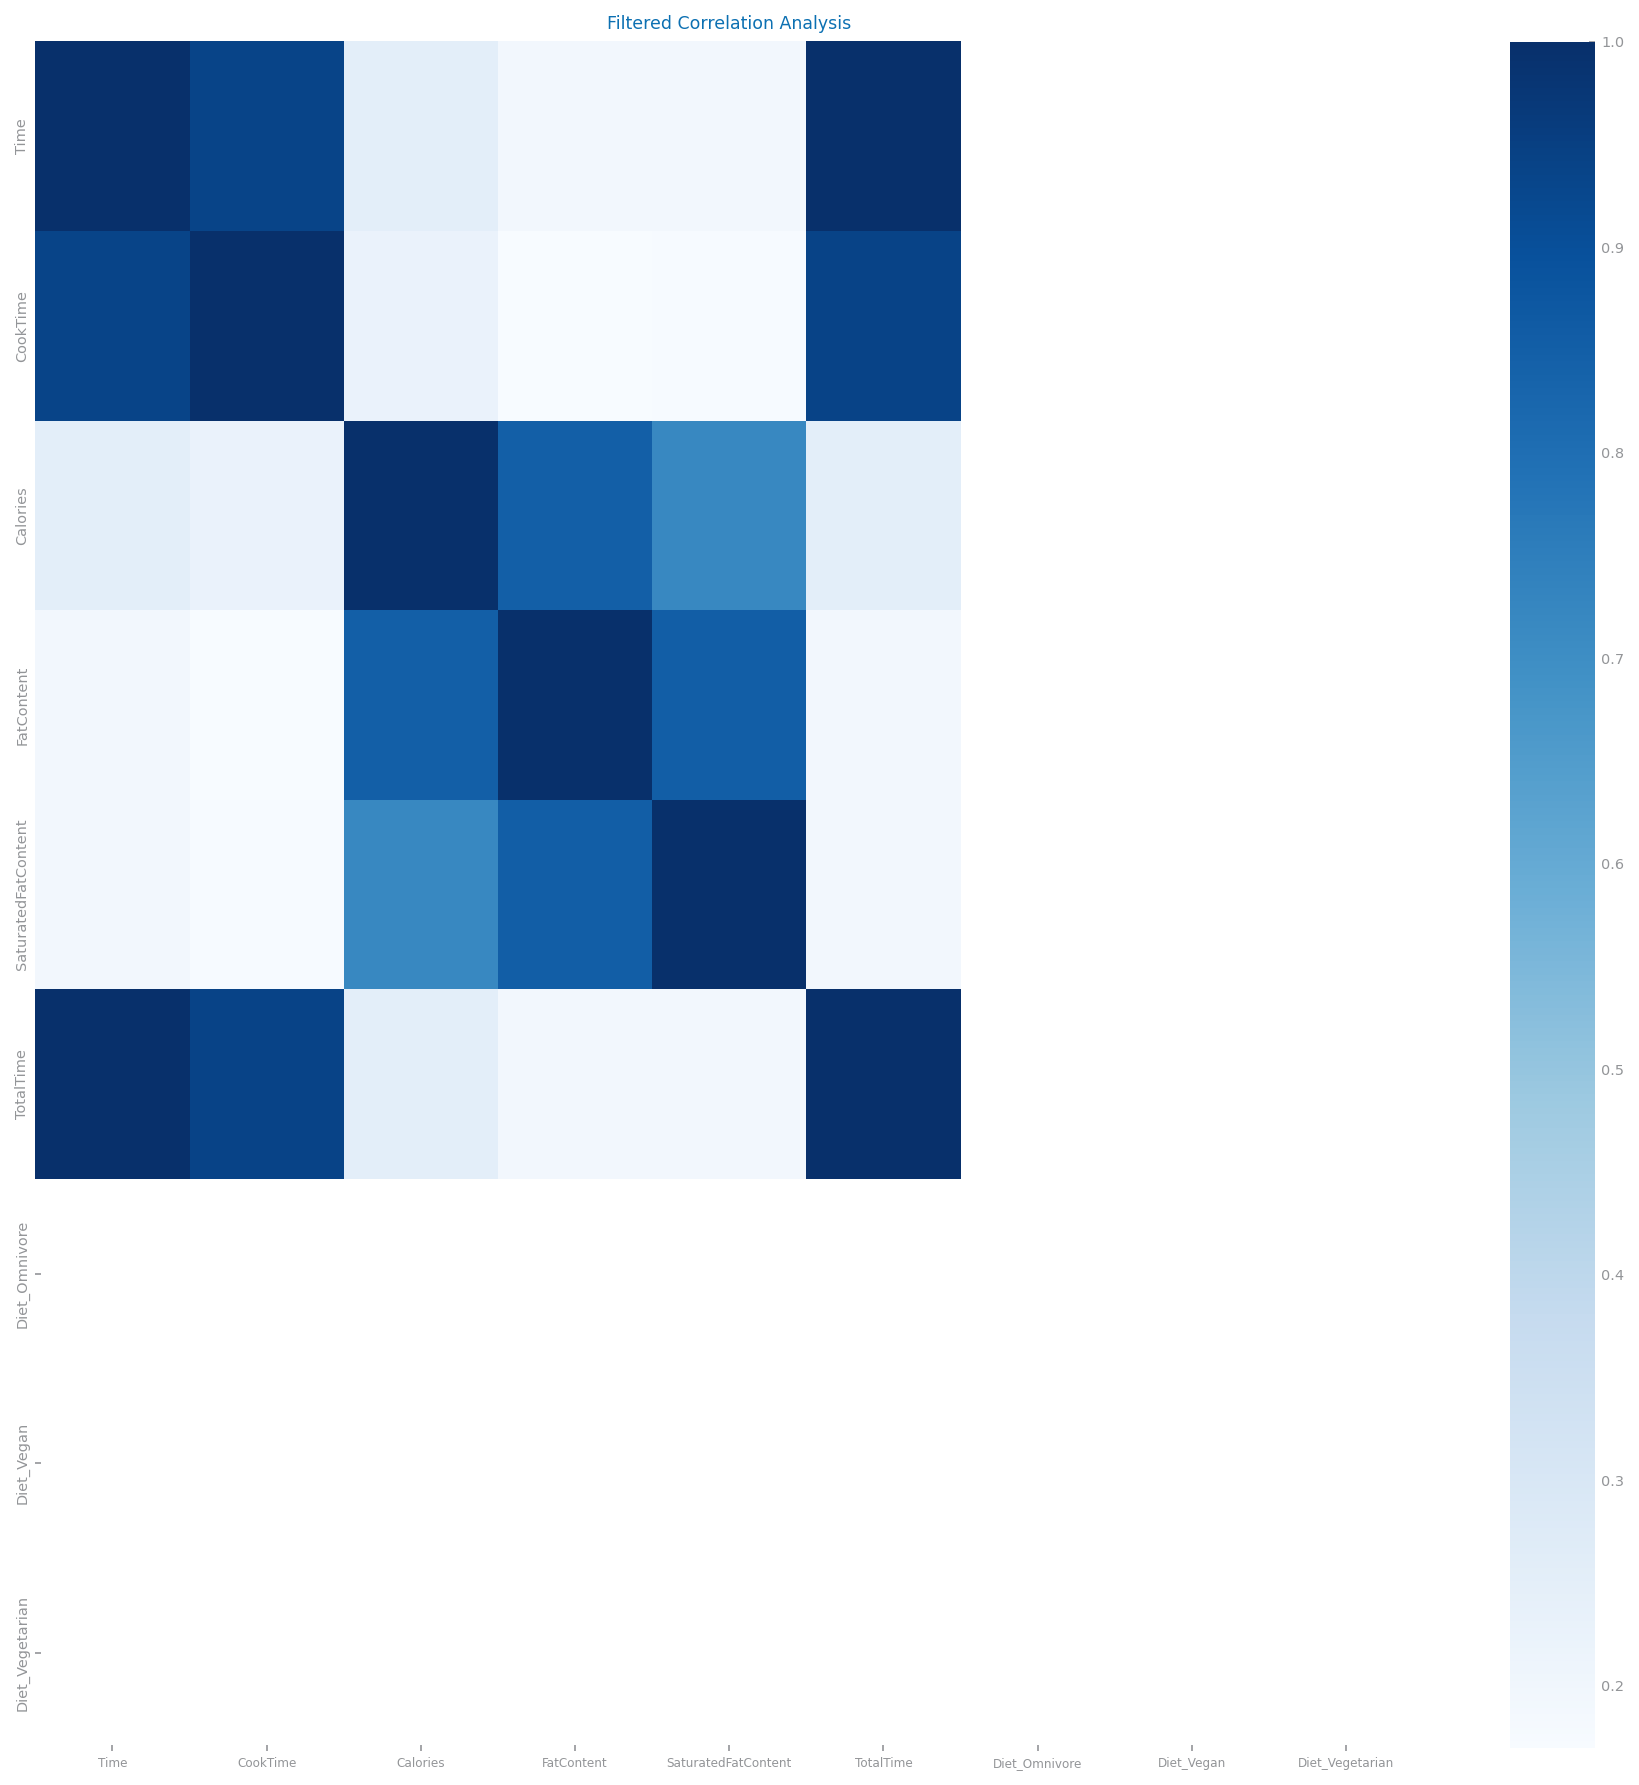

In [191]:
import pandas as pd
from matplotlib.pyplot import figure, title, savefig, show, tight_layout
from seaborn import heatmap

# Best option: dataset_rating_drop_recipe_mean
file_source_path = 'datasets/scaling/dataset_scaled_minmax.csv' # source file
file_dir = 'datasets/outliers' # destination directory
file_tag = 'dataset'

# read the data
df = pd.read_csv(file_source_path, low_memory=False)
# convert_variable_types(df)
index_column = df.columns[0]
df.drop([index_column], axis=1, inplace=True)

# ---------------------------- #
# Dropping Redundant Variables #
# ---------------------------- #

THRESHOLD = 0.8

def select_redundant(corr_mtx, threshold: float) -> tuple[dict, DataFrame]:
    if corr_mtx.empty:
        return {}

    corr_mtx = abs(corr_mtx)
    vars_2drop = {}
    for el in corr_mtx.columns:
        el_corr = (corr_mtx[el]).loc[corr_mtx[el] >= threshold]
        if len(el_corr) == 1:
            corr_mtx.drop(labels=el, axis=1, inplace=True)
            corr_mtx.drop(labels=el, axis=0, inplace=True)
        else:
            vars_2drop[el] = el_corr.index
    return vars_2drop, corr_mtx

drop, corr_mtx = select_redundant(df.corr(), THRESHOLD)
# print("Redundancies: ", drop.keys())

if corr_mtx.empty:
    raise ValueError('Matrix is empty.')

figure(figsize=[12, 12])
heatmap(corr_mtx, xticklabels=corr_mtx.columns, yticklabels=corr_mtx.columns, annot=False, cmap='Blues')
title('Filtered Correlation Analysis')
tight_layout()
show()

In [192]:
def drop_redundant(data: DataFrame, vars_2drop: dict) -> DataFrame:
    sel_2drop = []
    for key in vars_2drop.keys():
        if key not in sel_2drop:
            for r in vars_2drop[key]:
                if r != key and r not in sel_2drop:
                    sel_2drop.append(r)
    print('Variables to drop: ', sel_2drop)
    df = data.copy()
    for var in sel_2drop:
        df.drop(labels=var, axis=1, inplace=True)
    return df

print("Variables before drop: ", drop.keys())
# df = drop_redundant(df, drop)

df.to_csv(f'datasets/feature_selection/{file_tag}_selected.csv', index=True)

Variables before drop:  dict_keys(['Time', 'CookTime', 'Calories', 'FatContent', 'SaturatedFatContent', 'TotalTime', 'Diet_Omnivore', 'Diet_Vegan', 'Diet_Vegetarian'])


In [183]:
# from charts import bar_chart_fs

# def select_low_variance(data: DataFrame, threshold: float) -> list:
#     lst_variables = []
#     lst_variances = []
#     for el in data.columns:
#         value = data[el].var()
#         if value <= threshold:
#             lst_variables.append(el)
#             lst_variances.append(value)

#     # print(len(lst_variables), lst_variables)
#     if len(lst_variables) == 0:
#         return []
#     else:
#         figure(figsize=[16, 10])
#         bar_chart_fs(lst_variables, lst_variances, title='Variance analysis', xlabel='variables', ylabel='variance', rotation=True)
#         tight_layout()
#         show()
#         return lst_variables

# numeric = get_variable_types(df)['Numeric']
# vars_2drop = select_low_variance(data[numeric], 0.15)

# if len(vars_2drop) > 0:
#     df = drop_redundant(df, vars_2drop)
#     print('Variables to drop: ', vars_2drop)
# else:
#     print('No variables to drop.')
    

### Feature Extraction

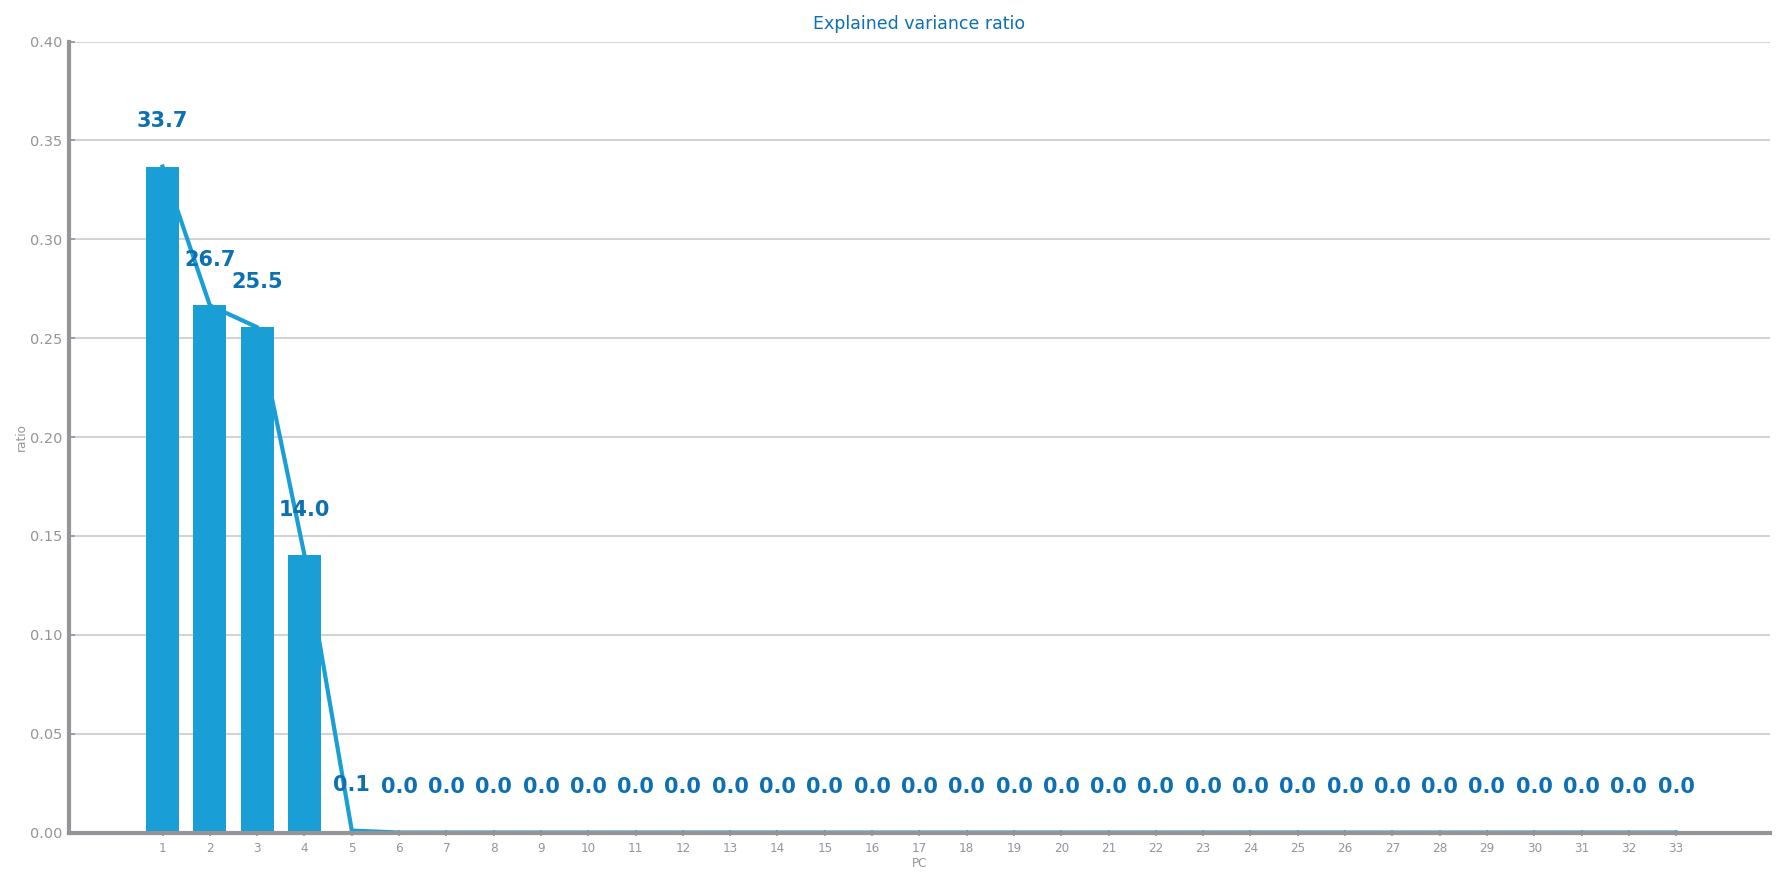

In [193]:
# TODO: check which variables contribute the most to the model using PCA
from sklearn.decomposition import PCA
from numpy.linalg import eig
from matplotlib.pyplot import gca, title
from matplotlib.pyplot import figure, xlabel, ylabel, scatter, show, subplots

# Best option: dataset_rating_drop_recipe_mean
file_source_path = 'datasets/feature_selection/dataset_selected.csv' # source file
file_tag = 'dataset'

# read the data
df = pd.read_csv(file_source_path, low_memory=False)
# convert_variable_types(df)
index_column = df.columns[0]
df.drop([index_column], axis=1, inplace=True)

df.pop('Like')
df.pop('TestSetId')
variables = df.columns.values

# print(df.info())

# ------- # 
#   PCA   #
# ------- # 

mean = (df.mean(axis=0)).tolist()
centered_data = df - mean
cov_mtx = centered_data.cov()
eigvals, eigvecs = eig(cov_mtx)

pca = PCA()
pca.fit(centered_data)
PC = pca.components_
var = pca.explained_variance_

# PLOT EXPLAINED VARIANCE RATIO
fig = figure(figsize=(12, 6))
title('Explained variance ratio')
xlabel('PC')
ylabel('ratio')
x_values = [str(i) for i in range(1, len(pca.components_) + 1)]
bwidth = 0.7
ax = gca()
ax.set_xticklabels(x_values)
ax.set_ylim(0.0, 0.4)
ax.bar(x_values, pca.explained_variance_ratio_, width=bwidth)
ax.plot(pca.explained_variance_ratio_)
for i, v in enumerate(pca.explained_variance_ratio_):
    ax.text(i, v+0.02, f'{v*100:.1f}', ha='center', fontweight='bold')
tight_layout()
show()

#### Sampling

Once we have a cleaned data set, and before we start the *Modelling* phase, we are going to split our data set into multiple sub-datasets. 
Here, we are going to balance the data to ensure that both classes are equally represented, and then split it into an *train* and *test* data set.

In [194]:
# split data into learning and test sets
from sklearn.model_selection import train_test_split

file_source_path = 'datasets/feature_selection/dataset_selected.csv' # source file
target = 'Like'

# read data
df = pd.read_csv(f'{file_source_path}', low_memory=False)
# convert variable types
# convert_variable_types(df)
# remove index column
index_column = df.columns[0]
df = df.drop([index_column], axis=1)
# Drop TestSetId column and Like NaN rows (no way to know if they liked or not)
df.drop('TestSetId', axis=1, inplace=True)
df.dropna(subset=[target], inplace=True)

print(df.shape)
# Take a random sample of 10k rows
df_test = df.sample(n=5000).copy(deep=True)

df_test.to_csv(f'df_test.csv', index=False)

df.drop(df_test.index, axis=0, inplace=True)
print(df.shape)

# ----------------------------- #
#           BALANCING           #
# ----------------------------- #

like_zero = df[df[target] == 0.0]
like_one = df[df[target] == 1.0]

df_one_sample = like_one.sample(len(like_zero), replace=True)
df_zero_sample = like_zero.sample(len(like_zero))

df = pd.concat([df_zero_sample, df_one_sample], axis=0)

# print(df.info())
# print(df[target].value_counts())

y = df.pop(target).values
X = df.values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                test_size=0.3, 
                shuffle=True,
                random_state=3)


(54234, 34)
(49234, 34)


### <font color='green'> Phase 4: Modeling </font>

In this phase, the model is trained and tuned. In general, data transformations
from data wrangling can be part of a machine learning pipeline, and can therefore
be tuned as well. (See CRISP-DM: DataPrep <--> Modeling)

In [195]:
# Here, you want to find the best classifier. As candidates, consider
#   1. LogisticRegression
#   2. RandomForestClassifier
#   3. other algorithms from sklearn (easy to add)
#   4. custom algorithms (more difficult to implement)
    
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

model_logistic_regression = LogisticRegression(max_iter=300)
model_random_forest = RandomForestClassifier()
model_gradient_boosting = GradientBoostingClassifier()
model_hist_gradient_boosting = HistGradientBoostingClassifier()

pipeline = Pipeline(steps=[("pca", PCA()),
                           ("model", None)])

parameter_grid_preprocessing = {
  # "pca__n_components" : [1, 2, 3, 4],
  "pca__n_components" : [df.shape[1]-12, df.shape[1]-8, df.shape[1]-5, df.shape[1]]
}

parameter_grid_logistic_regression = {
  "model" : [model_logistic_regression],
  "model__C" : [0.1, 1, 10],  # inverse regularization strength
}

parameter_grid_gradient_boosting = {
  "model" : [model_gradient_boosting],
  "model__n_estimators" : [100],
  "model__max_depth" : [4],
  "model__learning_rate" : [0.2],
}

# This estimator is much faster than GradientBoostingClassifier for big datasets (n_samples >= 10 000).
parameter_grid_hist_gradient_boosting = {
  "model" : [model_hist_gradient_boosting],
  "model__learning_rate" : [0.2], 
  "model__max_depth" : [4],
  # "model__max_depth" : [10, 15, 20, df.shape[1]],
}

parameter_grid_random_forest = {
  "model" : [model_random_forest],
  "model__n_estimators" : [10, 20, 50],  # number of max trees in the forest
  "model__max_depth" : [5, 10, 15],
}

meta_parameter_grid = [
                      #  parameter_grid_logistic_regression,
                      #  parameter_grid_random_forest] #,
                      #  parameter_grid_gradient_boosting #,
                       parameter_grid_hist_gradient_boosting]

meta_parameter_grid = [{**parameter_grid_preprocessing, **model_grid}
                       for model_grid in meta_parameter_grid]

search = GridSearchCV(pipeline,
                      meta_parameter_grid, 
                      scoring="balanced_accuracy",
                      n_jobs=-1, 
                      cv=5,  # number of folds for cross-validation 
                      error_score="raise"
)

# here, the actual training and grid search happens
search.fit(X_train, y_train.ravel())

print("best parameter:", search.best_params_ ,"(CV score=%0.3f)" % search.best_score_)

best parameter: {'model': HistGradientBoostingClassifier(learning_rate=0.2, max_depth=4), 'model__learning_rate': 0.2, 'model__max_depth': 4, 'pca__n_components': 28} (CV score=0.841)


### <font color='green'> Step 5: Evaluation </font>

Once the appropriate models are chosen, they are evaluated on the test set. For
this, different evaluation metrics can be used. Furthermore, this step is where
the models and their predictions are analyzed resp. different properties, including
feature importance, robustness to outliers, etc.

In [178]:
# evaluate performance of model on test set
print("Score on test set:", search.score(X_test, y_test.ravel()))

# contingency table
ct = pd.crosstab(search.best_estimator_.predict(X_test), y_test.ravel(),
                 rownames=["pred"], colnames=["true"])
print(ct)

Score on test set: 0.8487447579779501
true   0.0    1.0
pred             
0.0   9319   1318
1.0   2176  10324


In [171]:
# (optional, if you're curious) 
# for a detailed look on the performance of the different models
def get_search_score_overview():
  for c,s in zip(search.cv_results_["params"],search.cv_results_["mean_test_score"]):
      print(c, s)

print(get_search_score_overview())

{'model': HistGradientBoostingClassifier(learning_rate=0.2, max_depth=4), 'model__learning_rate': 0.2, 'model__max_depth': 4, 'pca__n_components': 18} 0.8249758713992505
{'model': HistGradientBoostingClassifier(learning_rate=0.2, max_depth=4), 'model__learning_rate': 0.2, 'model__max_depth': 4, 'pca__n_components': 22} 0.8341917292877092
{'model': HistGradientBoostingClassifier(learning_rate=0.2, max_depth=4), 'model__learning_rate': 0.2, 'model__max_depth': 4, 'pca__n_components': 25} 0.841322782754548
{'model': HistGradientBoostingClassifier(learning_rate=0.2, max_depth=4), 'model__learning_rate': 0.2, 'model__max_depth': 4, 'pca__n_components': 30} 0.8362994796695398
None


### <font color='green'> Step 6: Deployment </font>

In [196]:
# ----------------------------------------------------------------- #
# TEST with a random sample of 10k rows from the original dataset   #
# ----------------------------------------------------------------- #

from sklearn.metrics import balanced_accuracy_score

# read data
df_test = pd.read_csv('df_test.csv', low_memory=False)
# convert variable types
# convert_variable_types(df_test)

def micro_service_classify_review_test(datapoint):
  # make sure the provided datapoints adhere to the correct format for model input
  
  # fetch your trained model
  model = search.best_estimator_

  # make prediction with the model
  prediction = model.predict(datapoint)

  return prediction

# Save the Like values in a vector
like_values = df_test['Like'].values

# Optionally, you can drop the 'Like' column from the sampled_df if you don't need it
df_test.drop('Like', axis=1, inplace=True)

# make the missing predictions for the Like column
df_test['Like'] = micro_service_classify_review_test(df_test.values)

# Calculate balanced accuracy
balanced_acc = balanced_accuracy_score(like_values, df_test['Like'])

print(f"Balanced Accuracy: {balanced_acc}")

Balanced Accuracy: 0.7974169253734684


In [ ]:
def micro_service_classify_review(datapoint):
  # make sure the provided datapoints adhere to the correct format for model input
  # 'TestSetId' is not a feature used for prediction
  datapoint = datapoint.drop('TestSetId', axis=1)
  # fetch your trained model
  model = search.best_estimator_

  # make prediction with the model
  prediction = model.predict(datapoint)

  return prediction


In the Analytics Cup, we need to export your prediction in a very specific output format. This is a csv file without an index and two columns, *id* and *prediction*. Note that the values in both columns need to be integer values, and especially in the *prediction* column either 1 or 0.

In [ ]:
file_source_path = 'datasets/feature_selection/dataset_selected.csv' # source file

# read data
df = pd.read_csv(f'{file_source_path}', low_memory=False)
# convert variable types
convert_variable_types(df)
# remove index column
index_column = df.columns[0]
df = df.drop([index_column], axis=1)

# keep only the rows without a Like value
df = df[df['Like'].isna()]
# remove the Like column
df.drop('Like', axis=1, inplace=True)

# make the missing predictions for the Like column
df['Like'] = micro_service_classify_review(df)

# create a dataset that contains only the column 
# with the TestSetId and the model prediction for Like
output = df[['TestSetId', 'Like']]

# rename the columns to match the required format
output = output.rename(columns={'TestSetId': 'id'})
output = output.rename(columns={'Like': 'prediction'})
submission = output.reindex(columns=["id", "prediction"])
# convert id and prediction to integer
submission['id'] = submission['id'].astype(int)
submission['prediction'] = submission['prediction'].astype(int)

# print(submission.head())

submission.to_csv('predictions_tugas.csv', index = False)
